In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
%matplotlib inline

from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


from imblearn.over_sampling import SMOTE

import numpy as np

import seaborn as sns

In [21]:
jeremy_processed_fp = '/home/jeremy/Desktop/projects/data/Annotation/processed_aita_2019_08.pickle'
aita = pd.read_pickle(jeremy_processed_fp)
aita = aita.sample(frac=1).reset_index(drop=True) #forgot what I have this step here for I think it's the numbered index reset
aita.shape

(18554, 38)

# going to undersample the Not the A-hole category
# also going to reduce to only two main classes
aita.drop(aita.index[0:5000], inplace = True)
aita.shape

In [22]:
# reduce to just YTA & NTA
aita = aita[aita['link_flair_text'].isin(['Not the A-hole', 'Asshole'])]
aita.groupby('link_flair_text').size().sort_values(ascending = False)

link_flair_text
Not the A-hole    11658
Asshole            3959
dtype: int64

In [23]:
# need to remove reddit post common words.. these are not part of the story but a function of posting on reddit
# also this keeps complaining I think it's depreciated but I'll take a look later
aita['proc_text'] = [x.replace('x200b', '') for x in aita['proc_text']]
aita['proc_text'] = [x.replace('edit', '') for x in aita['proc_text']]
aita['proc_text'] = [x.replace('removed', '') for x in aita['proc_text']]
aita['proc_text'] = [x.replace('deleted', '') for x in aita['proc_text']]
#aita['proc_title'] = [x.replace('x200b', '') for x in aita['proc_title']]

### this is a cell you can run if you prefer to undersample but I am going to try SMOTE instead
YTA = aita.loc[aita['link_flair_text'] == 'Asshole'].sort_values('created_utc').copy()
print(YTA.shape)
NTA = aita.loc[aita['link_flair_text'] == 'Not the A-hole'].sort_values('created_utc').copy()
NTA = NTA.iloc[0:YTA.shape[0]] # cut down NTA to even sampling with YTA
print(NTA.shape)
del aita
aita = pd.concat([YTA, NTA])

aita.groupby('link_flair_text').size().sort_values(ascending = False)

In [24]:
label_id_df = aita[['link_flair_text', 'label_id']].drop_duplicates()

# Dictionaries for future use
label_to_id = dict(label_id_df.values)
id_to_label = dict(label_id_df[['label_id', 'link_flair_text']].values)

print(label_to_id)

{'Not the A-hole': 0, 'Asshole': 2}


In [25]:
#maybe we want to look at 
aita.head()

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,selftext,saved,id,from_kind,gilded,from,stickied,retrieved_on,over_18,thumbnail,subreddit_id,hide_score,link_flair_css_class,author_flair_css_class,archived,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,title_length,post_length,label_id,proc_title,proc_text
0,1554693930,AmItheAsshole,[deleted],self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,23,29,None,None,AITA for refusing to give up my clothes?,So I’m in a long distance relationship. Aroun...,None,baotsn,None,0,None,False,1560468009,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/baotsn/aita_for_refu...,None,None,False,Not the A-hole,None,8,109,0,refusing give clothes,long distance relationship around 10 hour flig...
1,1548452351,AmItheAsshole,orbitalexplosion,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,92,411,None,None,AITA for disinviting my friend to my bachelor ...,"I am getting married Sunday, we are having my ...",None,ajtz56,None,0,None,False,1552709885,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/ajtz56/aita_for_disi...,None,None,False,Not the A-hole,None,9,183,0,disinviting friend bachelor party,getting married sunday bachelor party vega rid...
2,1561208774,AmItheAsshole,seven1five,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,21,157,None,None,AITA if I no longer want to be the maid of hon...,I've moved from home the other side of the cou...,None,c3phei,None,0,None,False,1566718665,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/c3phei/aita_if_i_no_...,None,None,False,Not the A-hole,None,19,574,0,longer want maid honour getting kicked house,moved home side country two year ago year end ...
3,1548467849,AmItheAsshole,creepygirlfriendhelp,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,35,28,None,None,AITA for wanting my girlfriend to stop looking...,"Throwaway, she doesn't use this subreddit but ...",None,ajwhcr,None,0,None,False,1552711060,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/ajwhcr/aita_for_want...,None,None,False,Not the A-hole,None,11,631,0,wanting girlfriend stop looking unsecured camera,throwaway use subreddit know account name want...
4,1558466482,AmItheAsshole,OrdinaryLadder,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,492,70,None,None,AITA for telling my boyfriend to fuck off sex-...,"I know relationship posts aren’t allowed, but ...",None,bremxf,None,0,None,False,1561026376,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/bremxf/aita_for_tell...,None,None,False,Not the A-hole,None,19,443,0,telling boyfriend fuck sex shaming past none ...,know relationship post allowed really trying g...


In [26]:
# I want to take a closer look at some of these parameters later
tfidf = TfidfVectorizer(max_df=0.8
                        , max_features=200000
                        , min_df=0.2
                        ,sublinear_tf=True
                        , ngram_range=(1, 3)
                        , stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(aita['proc_text']).toarray()

labels = aita.label_id

print("Each of the %d posts is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 15617 posts is represented by 41 features (TF-IDF score of unigrams and bigrams)


In [27]:
# something is super not right here since I'm getting the same results for both
# Finding the three most correlated terms with each of the product categories
N = 3
for label, label_id in sorted(label_to_id.items()):
    features_chi2 = chi2(features, labels == label_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    #trigrams = [v for v in feature_names if len(v.split(' ')) == 3] # not sure why this isn't working
    print("\n==> %s:" %(label))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
    #print("  * Most Correlated Trigrams are: %s" %(', '.join(trigrams[-N:])))


==> Asshole:
  * Most Correlated Unigrams are: think, home, house
  * Most Correlated Bigrams are: 

==> Not the A-hole:
  * Most Correlated Unigrams are: think, home, house
  * Most Correlated Bigrams are: 


In [40]:
## want to fit SMOTE right here. Going to feed TFIDF below first and then go back and SMOTE it
seed = 420
k = 5 #need to adjust the # of neighbors we want here
sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)
X_res, y_res = sm.fit_resample(features, labels)

In [46]:
# so we added
print(aita.groupby('link_flair_text').size().sort_values(ascending = False))
print('\n Now feature size after SMOTE')
#print(len(features) , len(X_res))

link_flair_text
Not the A-hole    11658
Asshole            3959
dtype: int64

 Now feature size after SMOTE
15617 23316


# NOT SURE THIS CELL IS DOING ANYTHING ANY MORE

# Train Test Split
X = aita['proc_text'] #features # Collection of documents
y = aita['label_id'] #labels # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)
#del aita

In [49]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto'),
]

x_data = X_res #features #here we can change whether we want regular data or the TFIDF or SMOTE
y_data = y_res #labels #here we can change out the labels to make sure they match the X

# 5 Cross-validation
# what this means is that it's going to create 5 splits in the data, train on 5 of them and test on 1
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, x_data, y_data, scoring='accuracy', n_jobs = -1, cv=CV) #idk why I have the above cell... I am using the features/labels here not the X/y
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [50]:
# need to double check how this is being calculated
# I am not manually creating a test set so perhaps it is happening up above

# really sketchy to me that these accuracies are the same? (note made when using regula TFIDF)

#after SMOTE accuracies look more normal, random forest performing the best

mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc



,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.560130,0.009664
LogisticRegression,0.560302,0.010187
MultinomialNB,0.560130,0.007781
RandomForestClassifier,0.688075,0.125646


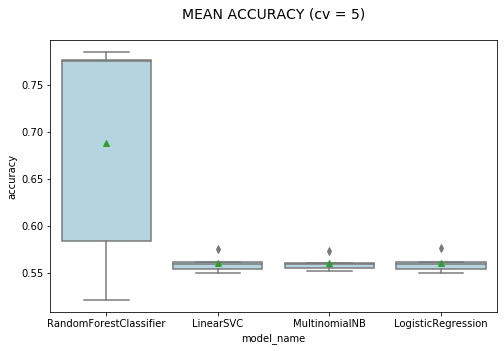

In [51]:
# currently displaying fit after SMOTE, random forrest performing best. 

plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);



# This is end of current work. Below is some tinkering
### Mainly trying to set up model to predict on any block of text

Model Evaluation

In [49]:
aita = pd.read_pickle('processed_aita.pickle')
aita.drop(aita.index[0:5000], inplace = True)
category_id_df = aita[['link_flair_text', 'label_id']].drop_duplicates()
aita.shape

(13554, 38)

In [50]:
aita.head()

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,selftext,saved,id,from_kind,gilded,from,stickied,retrieved_on,over_18,thumbnail,subreddit_id,hide_score,link_flair_css_class,author_flair_css_class,archived,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,title_length,post_length,label_id,proc_title,proc_text
33684,1558997784,AmItheAsshole,aita_couch,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,174,209,None,None,AITA - GF mad I got upset after she started ma...,Today my gf was supposed to be busy at lunch b...,None,btskhu,None,0,None,False,1561069807,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/btskhu/aita_gf_mad_i...,None,None,False,Not the A-hole,None,14,441,0,gf mad got upset started masturbating gay porn,today gf supposed busy lunch ended free see mi...
21740,1560622049,AmItheAsshole,somewhatwantedvirus,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,174,949,None,None,AITA when I refused a face tattoo of a mother'...,Earlier I had to refuse a tattoo to a mother....,None,c1084p,None,0,None,False,1566317598,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/c1084p/aita_when_i_r...,None,None,False,Not the A-hole,None,15,77,0,refused face tattoo mother dead son cheek,earlier refuse tattoo mother wanted last heart...
19304,1547649017,AmItheAsshole,SevereTension,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,174,229,None,None,AITA For doubting that my (M18) ex (F16) was r...,I dated this girl December last year until Oct...,None,aglnsi,None,0,None,False,1552655340,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/aglnsi/aita_for_doub...,None,None,False,Asshole,None,10,566,1,doubting m18 ex f16 raped,dated girl december last year october year rea...
12407,1555283607,AmItheAsshole,JillMarieDaane,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,174,164,None,None,WIBTA If we don’t have booze at our wedding?,Weddings are events of love and celebration. T...,None,bd8z1s,None,0,None,False,1560512212,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/bd8z1s/wibta_if_we_d...,None,None,False,Not the A-hole,None,9,290,0,booze wedding,wedding event love celebration majority friend...
33625,1556888422,AmItheAsshole,mrdrino27,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,174,369,None,None,AITA for not staying home with my sick kid?,Three of my best friends who I hardly ever see...,None,bk87n7,None,0,None,False,1560638186,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/bk87n7/aita_for_not_...,None,None,False,Asshole,None,9,297,1,staying home sick kid,three best friend hardly ever see flew visit w...


In [51]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               aita.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

ValueError: Found input variables with inconsistent numbers of samples: [7918, 7918, 13554]

In [ ]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= aita['link_flair_text'].unique()))

In [ ]:
# Really heavily predicting not the asshole here might be a sampling issue.. might cut down to just two categories
# a perfect score is down the diagonal
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.link_flair_text.values, 
            yticklabels=category_id_df.link_flair_text.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

## Alright stopping here for now I will go on in a bit

In [ ]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 
                                                                'Consumer_complaint']])
      print('')

In [ ]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))

Predictions

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.25,
#                                                     random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [ ]:
def preprocess(sentence):
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(lemmas)

In [ ]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

In [ ]:


df2[df2['Consumer_complaint'] == new_complaint]

